<a href="https://colab.research.google.com/github/toanvoduc27/Project-1/blob/main/stock_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd

# Lấy dữ liệu AAPL 5 năm gần nhất
data = yf.download('AAPL', start='2019-01-01', end='2024-01-01', progress=False)

data.head()


/tmp/ipython-input-335216929.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL', start='2019-01-01', end='2024-01-01', progress=False)


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2019-01-02,37.575207,37.796491,36.697214,36.854254,148158800
2019-01-03,33.832447,34.672369,33.787238,34.258355,365248800
2019-01-04,35.276730,35.345734,34.215527,34.389221,234428400
2019-01-07,35.198200,35.412347,34.715186,35.381414,219111200
2019-01-08,35.869202,36.123797,35.338600,35.586054,164101200


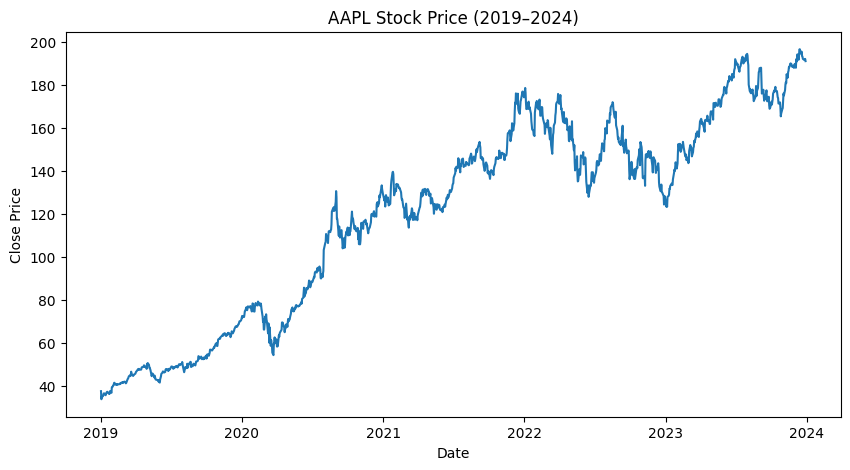

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
plt.plot(data['Close'])
plt.title('AAPL Stock Price (2019–2024)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()


In [3]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -1.2050001640120063
p-value: 0.671441077380803


In [4]:
data_diff = data['Close'].diff().dropna()

from statsmodels.tsa.stattools import adfuller
result = adfuller(data_diff)
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -36.964987030964295
p-value: 0.0


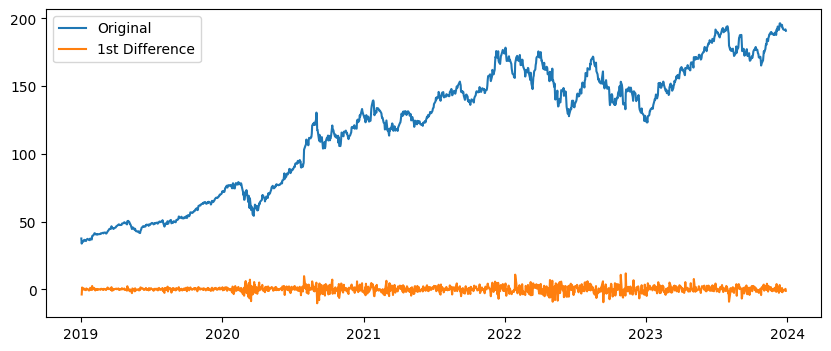

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(data['Close'], label='Original')
plt.plot(data_diff, label='1st Difference')
plt.legend()
plt.show()


In [6]:
train = data['Close'][:-30]
test = data['Close'][-30:]


In [7]:
from statsmodels.tsa.arima.model import ARIMA

train = data['Close'][:-30]
test = data['Close'][-30:]

model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

forecast = model_fit.forecast(steps=30)


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

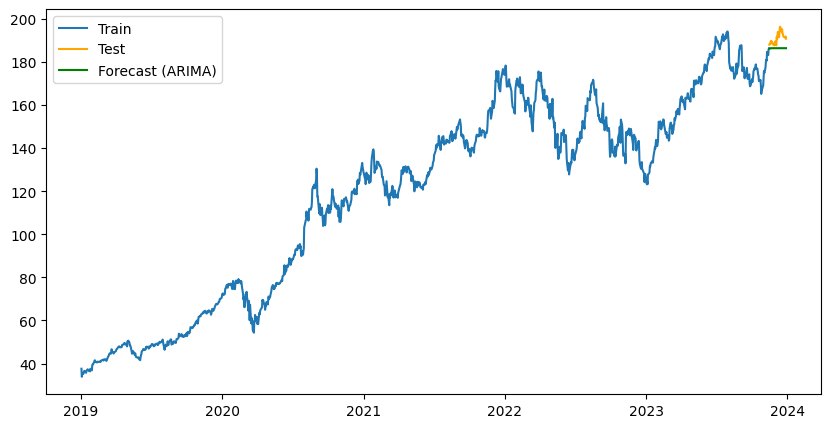

In [8]:
plt.figure(figsize=(10,5))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='orange')
plt.plot(test.index, forecast, label='Forecast (ARIMA)', color='green')
plt.legend()
plt.show()


In [9]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test, forecast))
print("ARIMA RMSE:", rmse)


ARIMA RMSE: 5.510252213630444


In [14]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size-60:]


In [15]:
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

# Reshape cho LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=30, batch_size=32)


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0947
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0040
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0015
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0015
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0014
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0014
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0013
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0013
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0013
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0012
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0013
Epoch 12/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0012
Epoch 13/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0012
Epoch 14/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0012
Epoch 15/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0011
Epoch 16/30
30/

In [21]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_real = scaler.inverse_transform(y_test.reshape(-1,1))

rmse_lstm = np.sqrt(mean_squared_error(y_test_real, predictions))
print("LSTM RMSE:", rmse_lstm)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
LSTM RMSE: 4.396276870117242


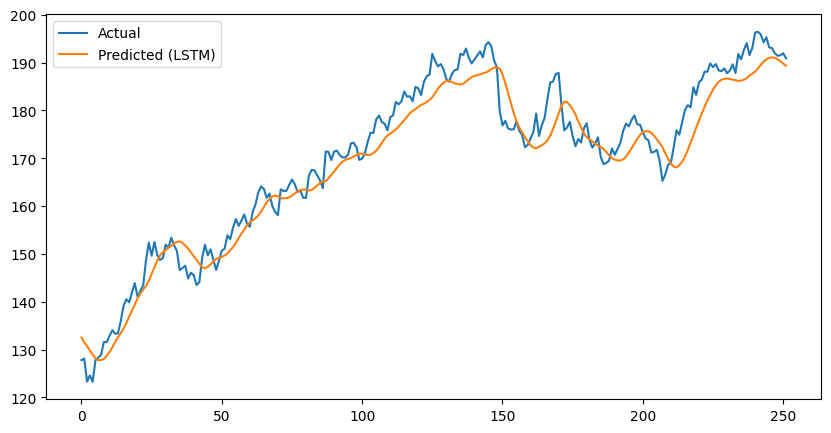

In [22]:
plt.figure(figsize=(10,5))
plt.plot(y_test_real, label='Actual')
plt.plot(predictions, label='Predicted (LSTM)')
plt.legend()
plt.show()
